In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import spacy
from spacy.tokens import Token
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import gutenberg, stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from collections import Counter

In [3]:
# Utility function for standard text cleaning
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'. 
    text = re.sub(r'--',' ',text)
    # get rid of text between brackets
    text = re.sub("[\[].*?[\]]", "", text)
    
    # Get rid of extra whitespace
    text = ' '.join(text.split())
    return text

In [4]:
milton = gutenberg.raw('milton-paradise.txt')
chesterton = gutenberg.raw('chesterton-brown.txt')

# Chapters are book specific
# Need to clear chapters before runnign clean text
chesterton = re.sub('[IVX][IVX]*\. *The.*', '', chesterton)
milton = re.sub(r'Book .*', '', milton)

milton_clean = text_cleaner(milton)
chesterton_clean = text_cleaner(chesterton)


In [5]:
# Parse the cleaned novels. 
nlp = spacy.load('en')
chesterton_doc = nlp(chesterton_clean)
milton_doc = nlp(milton_clean)



In [7]:
# Group into sentences
chesterton_sents = [[sent, 'Chesterton'] for sent in chesterton_doc.sents]
milton_sents = [[sent, 'Milton'] for sent in milton_doc.sents]

# Combine the setnences from the two novels into one data frame
sentences = pd.DataFrame(chesterton_sents + milton_sents)
sentences.columns = ['text_sentences', 'author']
sentences.head()

both_sents = [' '.join([token.lemma_ for token in sent]) for sent in sentences['text_sentences']]

both_pos = [' '.join([token.pos_ for token in sent]) for sent in sentences['text_sentences']]

In [8]:
both_sents[0:5]

['the consulting - room of dr orion hood , the eminent criminologist and specialist in certain moral disorder , lie along the sea - front at scarborough , in a series of very large and well - light french window , which show the north sea like one endless outer wall of blue - green marble .',
 'in such a place the sea have something of the monotony of a blue - green dado : for the chamber -PRON- be rule throughout by a terrible tidiness not unlike the terrible tidiness of the sea .',
 "-PRON- must not be suppose that dr hood 's apartment exclude luxury , or even poetry .",
 'these thing be there , in -PRON- place ; but one feel that -PRON- be never allow out of -PRON- place .',
 'luxury be there : there stand upon a special table eight or ten box of the good cigar ; but -PRON- be build upon a plan so that the strong be always nearest the wall and the mildest nearest the window .']

In [9]:
both_pos[0:5]

['DET NOUN PUNCT NOUN ADP PROPN PROPN PROPN PUNCT DET ADJ NOUN CCONJ NOUN ADP ADJ ADJ NOUN PUNCT VERB ADP DET NOUN PUNCT NOUN ADP PROPN PUNCT ADP DET NOUN ADP ADV ADJ CCONJ ADV PUNCT VERB ADJ NOUN PUNCT ADJ VERB DET PROPN PROPN ADP NUM ADJ ADJ NOUN ADP ADJ PUNCT ADJ NOUN PUNCT',
 'ADP ADJ DET NOUN DET NOUN VERB NOUN ADP DET NOUN ADP DET ADJ PUNCT ADJ NOUN PUNCT ADP DET NOUN PRON VERB VERB ADP ADP DET ADJ NOUN ADV ADP DET ADJ NOUN ADP DET NOUN PUNCT',
 'PRON VERB ADV VERB VERB ADP PROPN PROPN PART NOUN VERB NOUN PUNCT CCONJ ADV NOUN PUNCT',
 'DET NOUN VERB ADV PUNCT ADP ADJ NOUN PUNCT CCONJ NUM VERB ADP PRON VERB ADV VERB ADP ADP ADJ NOUN PUNCT',
 'PROPN VERB ADV PUNCT ADV VERB ADP DET ADJ NOUN NUM CCONJ NUM NOUN ADP DET ADJ NOUN PUNCT CCONJ PRON VERB VERB ADP DET NOUN ADP ADP DET ADJ VERB ADV ADP DET NOUN CCONJ DET NOUN ADP DET NOUN PUNCT']

In [11]:
vectorizer = CountVectorizer(max_features=2000, min_df=10, stop_words=STOP_WORDS)
X = vectorizer.fit_transform(both_sents)
print(vectorizer.get_feature_names()[0:20])
print(X.toarray())  


['able', 'abruptly', 'absence', 'absent', 'abyss', 'accept', 'accord', 'account', 'accuse', 'achieve', 'act', 'action', 'actor', 'adam', 'add', 'address', 'admiral', 'admiration', 'admire', 'admit']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
X

<6465x1429 sparse matrix of type '<class 'numpy.int64'>'
	with 50961 stored elements in Compressed Sparse Row format>

In [13]:
vectorizer_pos = CountVectorizer(max_features=200)
X_pos = vectorizer_pos.fit_transform(both_pos)
print(vectorizer_pos.get_feature_names())


['adj', 'adp', 'adv', 'cconj', 'det', 'intj', 'noun', 'num', 'part', 'pron', 'propn', 'punct', 'sym', 'verb']


# Random Forest Classifier

In [14]:
rfc = RandomForestClassifier(n_estimators=10)
Y = sentences['author']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=0.4, 
                                                    random_state=0)

train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9824697086878061

Test set score: 0.865815931941222


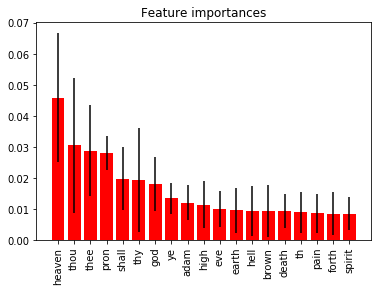

In [15]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[:-20:-1]


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), np.array(vectorizer.get_feature_names())[indices],
          rotation='vertical')
plt.show()

# Logistic Regression

In [16]:
lr = LogisticRegression(solver='liblinear')
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(3879, 1429) (3879,)
Training set score: 0.9641660221706625

Test set score: 0.9164733178654292


# Include Punctuation

In [17]:
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
df_pos = pd.DataFrame(X_pos.toarray(), columns=vectorizer_pos.get_feature_names())
df = df.join(df_pos, lsuffix='_sent', rsuffix='_pos')
df['author'] = Y

In [18]:
X3 = df.drop('author', axis=1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,
                                                    Y, 
                                                    test_size=0.4, 
                                                    random_state=0)

rfc = RandomForestClassifier(n_estimators=10)
train = rfc.fit(X_train3, y_train3)

print('Training set score:', rfc.score(X_train3, y_train3))
print('\nTest set score:', rfc.score(X_test3, y_test3))

Training set score: 0.9899458623356535

Test set score: 0.8747099767981439


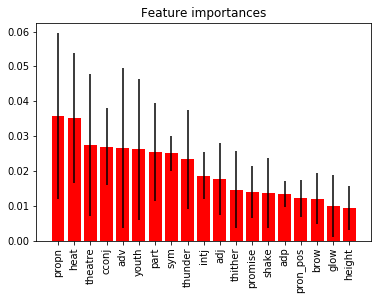

In [19]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[:-20:-1]


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), df.columns[indices],
          rotation='vertical')
plt.show()

In [20]:
lr = LogisticRegression(solver='liblinear')
train = lr.fit(X_train3, y_train3)
print('Training set score:', lr.score(X_train3, y_train3))
print('\nTest set score:', lr.score(X_test3, y_test3))

Training set score: 0.9677751997937613

Test set score: 0.9238205723124516


# Try adding entities

- didn't make much of a difference

In [26]:
# Try adding entities
# Extract the first ten entities.
entities = list(chesterton_doc.ents)[0:10]
for entity in entities:
    print(entity.label_, ' '.join(t.orth_ for t in entity))
    
# All of the uniqe entities spaCy thinks are locations.
location = [entity.text for entity in list(chesterton_doc.ents) if entity.label_ == "LOC"]

print(set(location))

# All of the uniqe entities spaCy thinks are locations.
location = [entity.text for entity in list(milton_doc.ents) if entity.label_ == "LOC"]
print(set(location))

PERSON Orion Hood
LOC the North Sea
PERSON Hood
CARDINAL one
PERSON Luxury
CARDINAL eight
CARDINAL ten
CARDINAL three
LANGUAGE English
LANGUAGE English
['the North Sea', 'the North Sea', 'Mediterranean', 'Europe', 'Paradise']
{'the Arabian Nights', 'Paradise', 'Thinker Boulnois', 'Asiatic', 'Cannibal Islands', 'Atlantic', 'English Government', 'the moon', 'Greywood Usher', 'Vosges', 'the Temple Gardens', 'Malvoli', 'Pacific', 'Pacific Islands', 'the moon a', 'Captain', 'Europe', 'Elizabethan', 'Theseus and Hippolyta', 'earth', 'Park', 'the Pacific Islands', 'Mediterranean', 'the Convict Settlement', 'the Western Sun', 'South Sea', 'the Cannibal Islands', 'the North Sea', 'Haroun Alraschid'}
{'Paradise', 'Sufficient', 'Earth Main', 'Encroaching Eve', 'Cape', 'the Earth Wheels', 'the Cape of Hope', 'Henceforth', 'Sea', 'East', 'the moon', 'Eden', 'Red-Sea', 'Earth', 'Holy', 'the east Darkness', 'Asia', 'Nile', 'Travelling east', 'India East', 'Active', 'Rhodope', 'the moon Globose', 'Arg

In [78]:
# Need to remove punctuation
table = str.maketrans(dict.fromkeys(string.punctuation))

# This is a bit much for a list comprehension
both_ents = [' '.join([''.join([ent.label_, ''.join(ent.text.translate(table).split())]) for ent in sent.ents]) for sent in sentences['text_sentences']]

In [79]:
vectorizer_ents = CountVectorizer(max_features=2000)
X_ents = vectorizer_ents.fit_transform(both_ents)
print(vectorizer_ents.get_feature_names())

['cardinal00021053', 'cardinalatleastthree', 'cardinalbetweentwo', 'cardinaleight', 'cardinalfive', 'cardinalfour', 'cardinalgabriel', 'cardinalhalf', 'cardinalhundred', 'cardinalhundreds', 'cardinalmillions', 'cardinalnine', 'cardinalone', 'cardinalonlyone', 'cardinalonlytwo', 'cardinalseven', 'cardinalsix', 'cardinalten', 'cardinaltenthousand', 'cardinaltenthousandthousand', 'cardinalthousands', 'cardinalthree', 'cardinaltwelve', 'cardinaltwenty', 'cardinaltwo', 'dateannual', 'datedaily', 'dateday', 'datedays', 'datedayspring', 'dateearlywinter', 'datefuturedays', 'datemanydays', 'datemay', 'datemeek', 'datemonths', 'datemorrow', 'datenow', 'dateoneday', 'datesaturday', 'dateseason', 'datesummer', 'datethatday', 'datetheday', 'datethedays', 'datethesixteenthcentury', 'datethisday', 'datetoday', 'datetomorrow', 'datetwodays', 'dateyear', 'dateyearly', 'dateyears', 'dateyesterday', 'eventchampion', 'eventthechampionarms', 'facangel', 'faccreatures', 'facmaker', 'facpendragonpark', 'fac

In [81]:
df_ents = pd.DataFrame(X_ents.toarray(), columns=vectorizer_ents.get_feature_names())
df_combined = df.join(df_ents, lsuffix='_orig', rsuffix='_ents')
df_combined.head()

,able,abruptly,absence,absent,abyss,accept,accord,account,accuse,achieve,...,work_of_arttheparadiseoffools,work_of_artthepassagemystery,work_of_artthepowersofheavensuch,work_of_artthepromisedlandtogodso,work_of_artthequeenofloveandbeauty,work_of_arttherisingsunset,work_of_artthesonofgod,work_of_artthethinkers,work_of_artvoodoo,work_of_artwearywillie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
X4 = df.drop('author', axis=1)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4,
                                                    Y, 
                                                    test_size=0.4, 
                                                    random_state=0)

rfc = RandomForestClassifier(n_estimators=10)
train = rfc.fit(X_train4, y_train4)

print('Training set score:', rfc.score(X_train4, y_train3))
print('\nTest set score:', rfc.score(X_test4, y_test4))

Training set score: 0.9904614591389533

Test set score: 0.8642691415313225


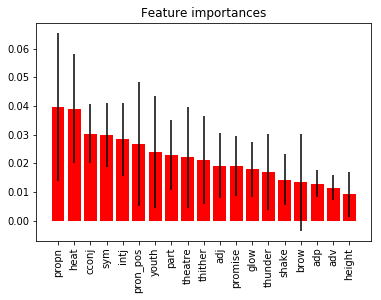

In [83]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[:-20:-1]


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), df.columns[indices],
          rotation='vertical')
plt.show()

In [84]:
lr = LogisticRegression(solver='liblinear')
train = lr.fit(X_train3, y_train3)
print('Training set score:', lr.score(X_train4, y_train4))
print('\nTest set score:', lr.score(X_test4, y_test4))

Training set score: 0.9677751997937613

Test set score: 0.9238205723124516


# Try adding all caps


In [93]:
both_caps = [sum([token.is_upper for token in sent]) for sent in sentences['text_sentences']]

In [97]:
df['all_caps'] = both_caps

In [99]:
X5 = df.drop('author', axis=1)
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5,
                                                    Y, 
                                                    test_size=0.4, 
                                                    random_state=0)

In [101]:
lr = LogisticRegression(solver='liblinear')
train = lr.fit(X_train5, y_train5)
print('Training set score:', lr.score(X_train5, y_train5))
print('\nTest set score:', lr.score(X_test5, y_test5))

Training set score: 0.9675174013921114

Test set score: 0.9238205723124516
